In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/transform/transformed_data.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   match_api_id                  3040 non-null   int64  
 1   season                        3040 non-null   object 
 2   stage                         3040 non-null   int64  
 3   date                          3040 non-null   object 
 4   away_team                     3040 non-null   int64  
 5   home_team                     3040 non-null   int64  
 6   home_team_goal                3040 non-null   int64  
 7   away_team_goal                3040 non-null   int64  
 8   result_match                  3040 non-null   int64  
 9   away_shoton                   3040 non-null   int64  
 10  home_shoton                   3040 non-null   int64  
 11  away_possession               3040 non-null   int64  
 12  home_possession               3040 non-null   int64  
 13  pla

In [3]:
cols_to_remove = ['result_match', 'match_api_id', 'season', 'date', 'away_team', 'home_team', 'away_team_goal', 'home_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton',]
# df[['season']] = df[['season']].astype('category')

In [4]:
# Splitting the original dataset
X = df.drop(cols_to_remove, axis=1)
y = df['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42, enable_categorical=True)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = f1_score(y_test, y_pred_full, average='weighted')

print(f'Base line accuracy: {accuracy_full}')

Base line accuracy: 0.48497368283301456


In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iterative_imputer = IterativeImputer()
df_iterative_imputed = iterative_imputer.fit_transform(X)

df_iterative_imputed = pd.DataFrame(df_iterative_imputed, columns=X.columns)

In [6]:
X_train_full, X_test_full, y_train, y_test = train_test_split(df_iterative_imputed, y, test_size=0.2, random_state=42)

xgb_full = XGBClassifier(random_state=42, enable_categorical=True)

xgb_full.fit(X_train_full, y_train)

y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = f1_score(y_test, y_pred_full, average='weighted')

print(f'Base line accuracy: {accuracy_full}')

Base line accuracy: 0.48867478674046455


In [7]:
df_ = df_iterative_imputed.copy()

In [8]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   stage                         3040 non-null   float64
 1   player_rating_home_player_1   3040 non-null   float64
 2   player_rating_home_player_2   3040 non-null   float64
 3   player_rating_home_player_3   3040 non-null   float64
 4   player_rating_home_player_4   3040 non-null   float64
 5   player_rating_home_player_5   3040 non-null   float64
 6   player_rating_home_player_6   3040 non-null   float64
 7   player_rating_home_player_7   3040 non-null   float64
 8   player_rating_home_player_8   3040 non-null   float64
 9   player_rating_home_player_9   3040 non-null   float64
 10  player_rating_home_player_10  3040 non-null   float64
 11  player_rating_home_player_11  3040 non-null   float64
 12  player_rating_away_player_1   3040 non-null   float64
 13  pla

In [9]:
X_train_full, X_test_full, y_train, y_test = train_test_split(df_, y, test_size=0.2, random_state=42)

xgb_full = XGBClassifier(random_state=42, enable_categorical=True)

xgb_full.fit(X_train_full, y_train)

y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = f1_score(y_test, y_pred_full, average='weighted')

print(f'Base line accuracy: {accuracy_full}')

Base line accuracy: 0.48867478674046455


In [10]:
def remove_highly_correlated_features(df, threshold=0.9,):
    """
    Removes features from the dataframe that have a correlation coefficient
    higher than the specified threshold.

    Parameters:
    df (pd.DataFrame): Dataframe with numerical features.
    threshold (float): Threshold for high correlation.

    Returns:
    tuple: (set of features to remove, reduced dataframe shape)
    """
    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Find feature pairs with correlation greater than the threshold
    # Interested in absolute value of correlation coefficient
    highly_correlated_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
    highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs >= threshold]
    highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs < 1]  # Remove self-correlation

    # Since correlation is symmetric, we'll take one of each pair
    # We will only take the first of the pair to remove.
    features_to_remove = set([pair[0] for pair in highly_correlated_pairs.index])

    print(features_to_remove)
    df_ = df.drop(columns=features_to_remove)
    print(df_.shape)
    
    return df_

data_reduced = remove_highly_correlated_features(X)

{'player_rating_home_player_1', 'player_rating_home_player_2', 'player_rating_away_player_1', 'player_rating_away_player_6', 'player_rating_away_player_4', 'player_rating_home_player_4', 'player_rating_away_player_5', 'player_rating_home_player_5', 'avg_away_team_rating', 'player_rating_away_player_3', 'player_rating_away_player_2', 'player_rating_home_player_6', 'avg_home_team_rating', 'player_rating_home_player_3'}
(3040, 23)


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   stage                         3040 non-null   int64  
 1   player_rating_home_player_1   3040 non-null   int64  
 2   player_rating_home_player_2   3040 non-null   int64  
 3   player_rating_home_player_3   3040 non-null   int64  
 4   player_rating_home_player_4   3040 non-null   int64  
 5   player_rating_home_player_5   3040 non-null   int64  
 6   player_rating_home_player_6   3040 non-null   int64  
 7   player_rating_home_player_7   3040 non-null   int64  
 8   player_rating_home_player_8   3040 non-null   int64  
 9   player_rating_home_player_9   3040 non-null   int64  
 10  player_rating_home_player_10  3040 non-null   int64  
 11  player_rating_home_player_11  3040 non-null   int64  
 12  player_rating_away_player_1   3040 non-null   int64  
 13  pla

In [12]:
# Clear negative correaltion between result_match and avg_palyer_rating_away

In [13]:
# List of player positions for which we have ratings
player_positions = range(1, 12)

# Calculate the difference from the average for each player
for position in player_positions:
    home_player_col = f'player_rating_home_player_{position}'
    away_player_col = f'player_rating_away_player_{position}'
    
    # Create new features for home and away players
    X[f'diff_player_{position}'] = X[home_player_col] - X[away_player_col]
    # data_reduced.drop([home_player_col, away_player_col], axis=1, inplace=True)

# Display the dataframe to confirm the new features
X.filter(like='diff_player').columns

Index(['diff_player_1', 'diff_player_2', 'diff_player_3', 'diff_player_4',
       'diff_player_5', 'diff_player_6', 'diff_player_7', 'diff_player_8',
       'diff_player_9', 'diff_player_10', 'diff_player_11'],
      dtype='object')

In [14]:
# def calculate_rolling_averages(rolling_window_size, df, stat_columns):
#     """
#     Calculate rolling averages for various statistics without including the current match.

#     Args:
#     - rolling_window_size (int): Number of previous matches to include in the rolling average.
#     - df (pd.DataFrame): The DataFrame containing the match data.
#     - stat_columns (dict): A dictionary with keys for each stat category (e.g., 'goals', 'possession', 'shots_on'),
#                            and values being another dictionary with 'home' and 'away' keys mapping to the respective columns.

#     Returns:
#     - pd.DataFrame: The DataFrame with new rolling average columns added.
#     """

#     # Iterate through each stat category
#     for stat, columns in stat_columns.items():
#         # Define new feature names for rolling features
#         home_feature_name = f'home_{stat}_rolling'
#         away_feature_name = f'away_{stat}_rolling'

#         # Calculate rolling averages for home and away statistics
#         for team_type in ['home', 'away']:
#             # Sort by team and date
#             df.sort_values(by=[f'{team_type}_team', 'date'], ascending=True, inplace=True)
            
#             # Calculate rolling averages for the given stat
#             df[home_feature_name if team_type == 'home' else away_feature_name] = (
#                 df.groupby(f'{team_type}_team')[columns[team_type]]
#                 .apply(lambda x: x.shift().rolling(window=rolling_window_size).mean())
#                 .reset_index(level=0, drop=True)
#             )
            
#             # Calculate the means for rolling features
#             rolling_means = df.groupby(f'{team_type}_team')[home_feature_name if team_type == 'home' else away_feature_name].transform('mean')
            
#             # Fill NaN values in rolling features with the team-specific means
#             df[home_feature_name if team_type == 'home' else away_feature_name] = (
#                 df[home_feature_name if team_type == 'home' else away_feature_name].fillna(rolling_means)
#             )

#     return df

In [15]:
# # Define a range of window sizes to test
# window_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15]

# # Define your statistical categories and their corresponding columns
# stat_columns = {
#     'goals': {
#         'home': 'home_team_goal',
#         'away': 'away_team_goal'
#     },
#     'shots_on': {
#         'home': 'home_shoton',
#         'away': 'away_shoton'
#     }
# }

# # Placeholder for best score and corresponding window size
# best_score = -float('inf')
# best_window_size = None

# # Iterate over window sizes to find the best one
# for window_size in window_sizes:
#     # Calculate rolling averages using the current window size
#     df_with_rolling = calculate_rolling_averages(window_size, df_numerical.copy(), stat_columns)

#     df_with_rolling = df_with_rolling.drop(['date', 'away_team', 'away_team_goal', 'home_team','home_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton'], axis=1)
    
#     # Extract features and target for model training
#     X = df_with_rolling.drop(['result_match'], axis=1)
#     y = df_with_rolling['result_match']
    
#     # Define your model
#     model = XGBClassifier(random_state=42)
    
#     # Perform cross-validation
#     scores = cross_val_score(model, X, y, cv=2, scoring='accuracy')
    
#     # Calculate the mean score
#     mean_score = scores.mean()
    
#     # Update best score and window size if current score is better
#     if mean_score > best_score:
#         best_score = mean_score
#         best_window_size = window_size

# # best_window_size now holds the size of the window that gave the best performance
# print(f"Best window size: {best_window_size} with score: {best_score}")

In [16]:
# df_with_rolling = calculate_rolling_averages(best_window_size, df=df_numerical.copy(), stat_columns=stat_columns)
# df_with_rolling = df_with_rolling.drop(['date', 'away_team', 'away_team_goal', 'home_team','home_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton'], axis=1)

In [17]:
# # Splitting the original dataset
# X = df_with_rolling.drop('result_match', axis=1)
# y = df_with_rolling['result_match']
# X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the XGBClassifier
# xgb_full = XGBClassifier(random_state=42)

# # Train the model on the full feature set
# xgb_full.fit(X_train_full, y_train)

# # Predictions and evaluation on the full feature set
# y_pred_full = xgb_full.predict(X_test_full)
# accuracy_full = accuracy_score(y_test, y_pred_full)

# accuracy_full

In [18]:
# df_with_rolling.info()

In [19]:
# Positive correlations are shown by bars extending above the horizontal line (y=0), 
# indicating that an increase in these features is associated with higher values of 'result_match'.

# Negative correlations, shown by bars below the line, 
# suggest that an increase in these features is associated with lower values of 'result_match'.

In [20]:
df_ = X.copy()

In [21]:
away_players_7_11 = ['player_rating_away_player_6', 'player_rating_away_player_7', 'player_rating_away_player_8', 'player_rating_away_player_9', 'player_rating_away_player_10', 'player_rating_away_player_11']

df_['avg_away_rating_attack'] = df_[away_players_7_11].mean(axis=1).round(2)

home_players_7_11 = ['player_rating_home_player_6', 'player_rating_home_player_7', 'player_rating_home_player_8', 'player_rating_home_player_9',
            'player_rating_home_player_10', 'player_rating_home_player_11']

df_['avg_home_rating_attack'] = df_[home_players_7_11].mean(axis=1).round(2)

away_players_1_5 = ['player_rating_away_player_1', 'player_rating_away_player_2', 'player_rating_away_player_3',
            'player_rating_away_player_4', 'player_rating_away_player_5']

df_['avg_away_rating_defence'] = df_[away_players_1_5].mean(axis=1).round(2)

home_players_1_5 = ['player_rating_home_player_1', 'player_rating_home_player_2', 'player_rating_home_player_3',
            'player_rating_home_player_4', 'player_rating_home_player_5', 'player_rating_home_player_6']

df_['avg_home_rating_defence'] = df_[home_players_1_5].mean(axis=1).round(2)

In [22]:
df_['diff_avg_rating_attack'] = df_['avg_home_rating_attack'] - df_['avg_away_rating_attack']
df_['diff_avg_rating_defence'] = df_['avg_home_rating_defence']  - df_['avg_away_rating_defence']

df_.drop(['avg_home_rating_attack', 'avg_away_rating_attack', 'avg_home_rating_defence', 'avg_away_rating_defence'], inplace=True, axis=1)

In [23]:
player_cols= ['player_rating_away_player_6', 'player_rating_away_player_7', 'player_rating_away_player_8', 
 'player_rating_away_player_9', 'player_rating_away_player_10', 'player_rating_away_player_11',
 'player_rating_home_player_6', 'player_rating_home_player_7', 'player_rating_home_player_8',
 'player_rating_home_player_9', 'player_rating_home_player_10', 'player_rating_home_player_11',
 'player_rating_away_player_1', 'player_rating_away_player_2', 'player_rating_away_player_3',
 'player_rating_away_player_4', 'player_rating_away_player_5', 'player_rating_home_player_1', 
 'player_rating_home_player_2', 'player_rating_home_player_3','player_rating_home_player_4',
 'player_rating_home_player_5', 'player_rating_home_player_6'
]

df_ = df_.drop(player_cols, axis=1)

In [24]:
# df_['rating_difference'] = df_['avg_home_team_rating'] - df_['avg_away_team_rating'] drastically lower

In [25]:
# df_corr = remove_highly_correlated_features(df_)

In [26]:
# Creating interaction features based on the report
# df_['interaction_depth1_1'] = df_['diff_avg_rating_attack'] * df_['ewma_shoton_home']
# df_['interaction_depth1_2'] = df_['away_team_ewm_goals'] *df_['away_team_ewm_goals_conceded']

# For depth 2 interactions, combining three features
# df_['interaction_depth2_1'] = df_['diff_avg_rating_attack']**2 * df_['avg_home_team_rating']

In [27]:
# Interaction Depth 1 examples
# df_['interaction_depth1_3'] = df_['away_streak_wins'] * df_['ewma_shoton_home']
df_['interaction_depth1_4'] = df_['ewma_shoton_away'] * df_['home_team_ewm_goals_conceded'] # +q
df_['interaction_depth1_5'] = df_['away_streak_wins'] * df_['away_team_ewm_goals'] # +q
# df_['interaction_depth1_6'] = df_['home_team_ewm_goals'] * df_['home_team_ewm_goals_conceded']

# Interaction Depth 2 examples
df_['interaction_depth2_2'] = df_['away_team_ewm_goals'] * df_['away_team_ewm_goals_conceded'] * df_['ewma_shoton_home'] # +q
# df_['interaction_depth2_3'] = df_['home_streak_wins'] * df_['away_streak_wins'] * df_['avg_home_team_rating']
# df_['interaction_depth2_4'] = df_['ewma_shoton_home'] * df_['home_team_ewm_goals'] * df_['avg_away_team_rating']

# Example of a more complex interaction
# df_['interaction_depth2_5'] = df_['diff_avg_rating_attack'] * df_['away_team_ewm_goals'] * df_['home_team_ewm_goals_conceded']


In [28]:
X_train_full, X_test_full, y_train, y_test = train_test_split(df_, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
accuracy_full = f1_score(y_test, y_pred_full, average='weighted')

accuracy_full

0.49671301849330673

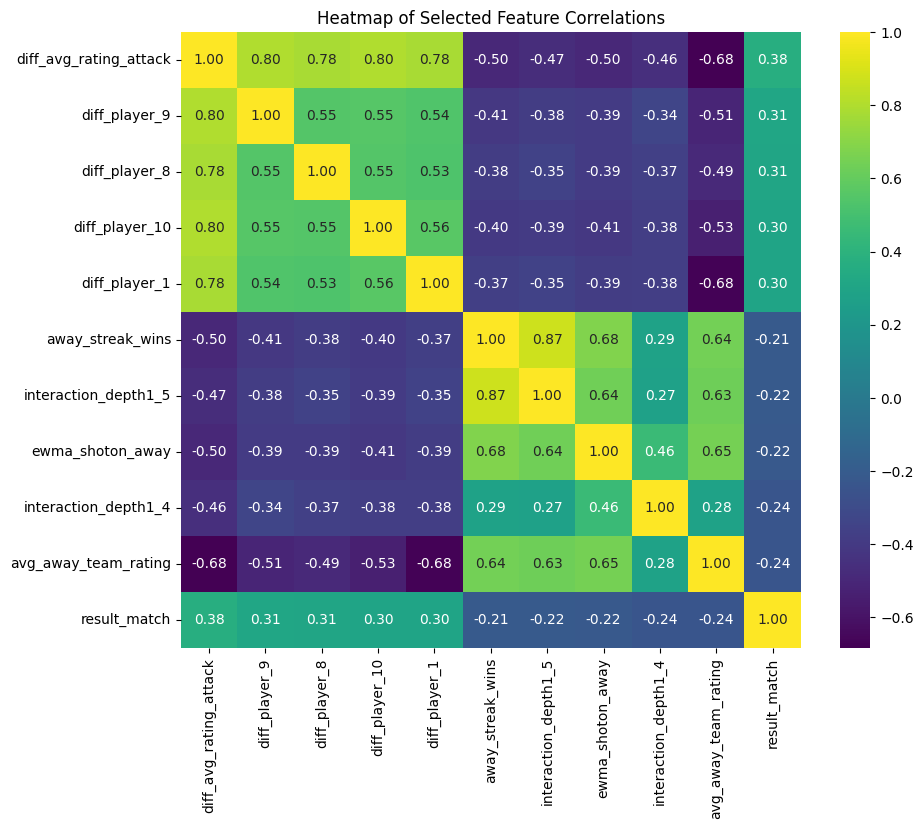

In [29]:
# Calculate the Pearson correlation matrix
correlation_matrix = df_.assign(result_match=y).corr()

# Extract the correlations with the target variable 'result_match'
correlations_with_target = correlation_matrix['result_match'].sort_values(ascending=False)

correlations_with_target

# Select the top 5 positively correlated and top 5 negatively correlated features (excluding the target itself)
top_positive_correlated_features = correlations_with_target.index[1:6].tolist()
top_negative_correlated_features = correlations_with_target.index[-5:].tolist()
selected_features = top_positive_correlated_features + top_negative_correlated_features

# Create a new dataframe with the selected features and the target variable
selected_data = df_.assign(result_match=y)[selected_features + ['result_match']]

# Create a heatmap for the selected features
plt.figure(figsize=(10, 8))
sns.heatmap(selected_data.corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Heatmap of Selected Feature Correlations')
plt.show()

In [30]:
import xgbfir

xgbfir.saveXgbFI(xgb_full, feature_names=X_train_full.columns, OutputXlsxFile='fir.xlsx')

file_path = 'fir.xlsx'
fir = pd.read_excel(file_path)

# Extracting top features based on different metrics
top_gain_features = fir.sort_values(by='Gain', ascending=False).head(10)
top_fscore_features = fir.sort_values(by='FScore', ascending=False).head(10)
top_wfscore_features = fir.sort_values(by='wFScore', ascending=False).head(10)
top_avg_gain_features = fir.sort_values(by='Average Gain', ascending=False).head(10)
top_expected_gain_features = fir.sort_values(by='Expected Gain', ascending=False).head(10)

# Displaying the top features
top_features_summary = {
    "Top Features by Gain": top_gain_features['Interaction'].values,
    "Top Features by FScore": top_fscore_features['Interaction'].values,
    "Top Features by wFScore": top_wfscore_features['Interaction'].values,
    "Top Features by Average Gain": top_avg_gain_features['Interaction'].values,
    "Top Features by Expected Gain": top_expected_gain_features['Interaction'].values
}

top_features_summary

{'Top Features by Gain': array(['diff_avg_rating_attack', 'away_team_ewm_goals_conceded',
        'ewma_shoton_home', 'home_streak_wins', 'ewma_shoton_away',
        'home_team_ewm_goals_conceded', 'avg_home_team_rating',
        'away_team_ewm_goals', 'home_team_ewm_goals',
        'interaction_depth2_2'], dtype=object),
 'Top Features by FScore': array(['away_team_ewm_goals_conceded', 'home_streak_wins',
        'ewma_shoton_home', 'home_team_ewm_goals',
        'home_team_ewm_goals_conceded', 'away_team_ewm_goals',
        'ewma_shoton_away', 'avg_home_team_rating', 'avg_away_team_rating',
        'interaction_depth2_2'], dtype=object),
 'Top Features by wFScore': array(['diff_avg_rating_attack', 'home_streak_wins', 'ewma_shoton_away',
        'avg_away_team_rating', 'away_team_ewm_goals_conceded',
        'ewma_shoton_home', 'away_team_ewm_goals', 'home_team_ewm_goals',
        'home_team_ewm_goals_conceded', 'avg_home_team_rating'],
       dtype=object),
 'Top Features by Average 

In [31]:
# Load the data from the "Interaction Depth 1" and "Interaction Depth 2" sheets
interaction_depth_1 = pd.read_excel(file_path, sheet_name='Interaction Depth 1')
interaction_depth_2 = pd.read_excel(file_path, sheet_name='Interaction Depth 2')

# Display the first few rows of each sheet to understand their structure
interaction_depth_1_head = interaction_depth_1.sort_values('Average Rank', ascending=False).head(20)
interaction_depth_2_head = interaction_depth_2.sort_values('Average Rank', ascending=False).head(20)

interaction_depth_1_head

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
95,diff_player_9|home_team_ewm_goals_conceded,44.173524,14,0.383242,0.027374,3.155252,1.690658,96,68,100,100,80,100,90.666667,50.428571,4.785714
98,home_streak_wins|home_weighted_wins,43.821056,16,0.647710,0.040482,2.738816,2.033832,99,45,98,96,98,98,89.000000,39.937500,2.750000
96,avg_home_team_rating|stage,44.061224,11,0.411437,0.037403,4.005566,1.714376,97,93,99,97,38,99,87.166667,48.818182,4.545455
77,diff_player_8|home_team_ewm_goals,46.854157,14,0.659343,0.047096,3.346725,2.790089,78,65,97,94,74,94,83.666667,40.714286,4.357143
89,diff_player_7|ewma_shoton_away,45.356945,16,1.185260,0.074079,2.834809,2.783407,90,44,82,81,96,95,81.333333,48.250000,4.000000
65,avg_home_team_rating|interaction_depth2_2,50.108567,13,0.702057,0.054004,3.854505,2.712531,66,74,96,92,44,96,78.000000,42.923077,4.384615
81,avg_home_team_rating|diff_player_1,46.361100,15,1.275107,0.085007,3.090740,4.033287,82,52,76,78,83,85,76.000000,49.000000,3.933333
79,away_weighted_wins|interaction_depth2_2,46.621709,9,0.712069,0.079119,5.180190,3.623194,80,97,95,80,15,88,75.833333,36.111111,4.000000
99,ewma_shoton_away|interaction_depth1_4,43.597596,8,0.824466,0.103058,5.449700,5.324095,100,100,91,66,13,75,74.166667,23.250000,3.750000
64,home_team_ewm_goals_conceded|stage,50.248008,15,1.067348,0.071157,3.349867,3.865101,65,50,84,85,73,87,74.000000,43.200000,4.600000


In [32]:
interaction_depth_2_head

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
98,ewma_shoton_away|home_streak_wins|interaction_...,27.151344,4,0.084772,0.021193,6.787836,0.560400,99,59,96,95,79,95,87.166667,19.750000,4.500000
86,ewma_shoton_home|home_team_ewm_goals|home_team...,28.426098,3,0.065281,0.021760,9.475366,0.523698,87,77,97,94,57,97,84.833333,39.333333,4.000000
97,avg_home_team_rating|away_team_ewm_goals|point...,27.180469,3,0.120067,0.040022,9.060156,1.075800,98,80,87,80,61,88,82.333333,11.000000,4.333333
85,away_team_ewm_goals|away_weighted_wins|interac...,28.522351,4,0.097962,0.024490,7.130588,0.842454,86,54,95,93,71,91,81.666667,39.000000,5.000000
78,avg_away_team_rating|diff_player_1|ewma_shoton...,30.119980,1,0.015214,0.015214,30.119980,0.458240,79,100,99,98,15,98,81.500000,2.000000,3.000000
84,diff_player_7|diff_player_9|interaction_depth2_2,28.580529,4,0.098352,0.024588,7.145132,0.811936,85,53,94,92,69,93,81.000000,44.500000,4.750000
92,away_team_ewm_goals_conceded|diff_avg_rating_a...,28.006207,5,0.135844,0.027169,5.601241,0.780967,93,34,83,90,91,94,80.833333,39.000000,3.800000
96,avg_away_team_rating|away_team_ewm_goals|ewma_...,27.318025,4,0.163753,0.040938,6.829506,0.813475,97,58,78,79,78,92,80.333333,30.750000,3.750000
63,diff_avg_rating_attack|interaction_depth1_4|stage,33.323313,1,0.008224,0.008224,33.323313,0.274040,64,98,100,99,13,99,78.833333,0.000000,3.000000
53,diff_avg_rating_attack|diff_avg_rating_attack|...,34.617216,6,0.040539,0.006757,5.769536,0.248165,54,16,98,100,88,100,76.000000,27.000000,3.500000


In [26]:
cols = ['away_team_ewm_goals_conceded', 'points_away', 'away_streak_wins', 'avg_home_team_rating',
 'avg_away_team_rating', 'diff_avg_rating_attack', 'diff_player_9', 'home_streak_wins',
 'diff_player_11', 'home_team_ewm_goals_conceded', 'stage', 'diff_player_8', 'ewma_shoton_away',
 'ewma_shoton_home', 'points_home', 'home_team_ewm_goals', 'diff_player_10']

In [27]:
(X_train_full
 .assign(result_match=y_train)
 .corr(method='spearman')
 .loc[:, ['away_team_ewm_goals_conceded', 'points_away', 'away_streak_wins', 'avg_away_team_rating', 'diff_avg_rating_attack', 'diff_player_1', 'home_team_ewm_goals_conceded']]
 .style
 .background_gradient(cmap='RdBu', vmin=-1, vmax=1)
 .format('{:.2f}')
)



,away_team_ewm_goals_conceded,points_away,away_streak_wins,avg_away_team_rating,diff_avg_rating_attack,diff_player_1,home_team_ewm_goals_conceded
stage,-0.03,0.88,0.09,0.02,-0.01,-0.02,0.00
home_team_ewm_goals,-0.04,0.03,0.03,0.03,0.31,0.24,-0.22
away_team_ewm_goals,-0.22,0.26,0.52,0.47,-0.34,-0.26,-0.01
home_team_ewm_goals_conceded,0.06,-0.04,-0.03,-0.02,-0.25,-0.22,1.00
away_team_ewm_goals_conceded,1.00,-0.28,-0.39,-0.40,0.29,0.23,0.06
points_home,-0.04,0.79,0.09,0.00,0.21,0.16,-0.24
points_away,-0.28,1.00,0.40,0.30,-0.22,-0.19,-0.04
home_weighted_wins,0.04,0.03,0.05,0.01,-0.28,-0.23,0.17
away_weighted_wins,-0.18,0.27,0.59,0.44,-0.34,-0.28,-0.01
avg_home_team_rating,0.00,-0.01,-0.03,-0.04,0.67,0.67,-0.38


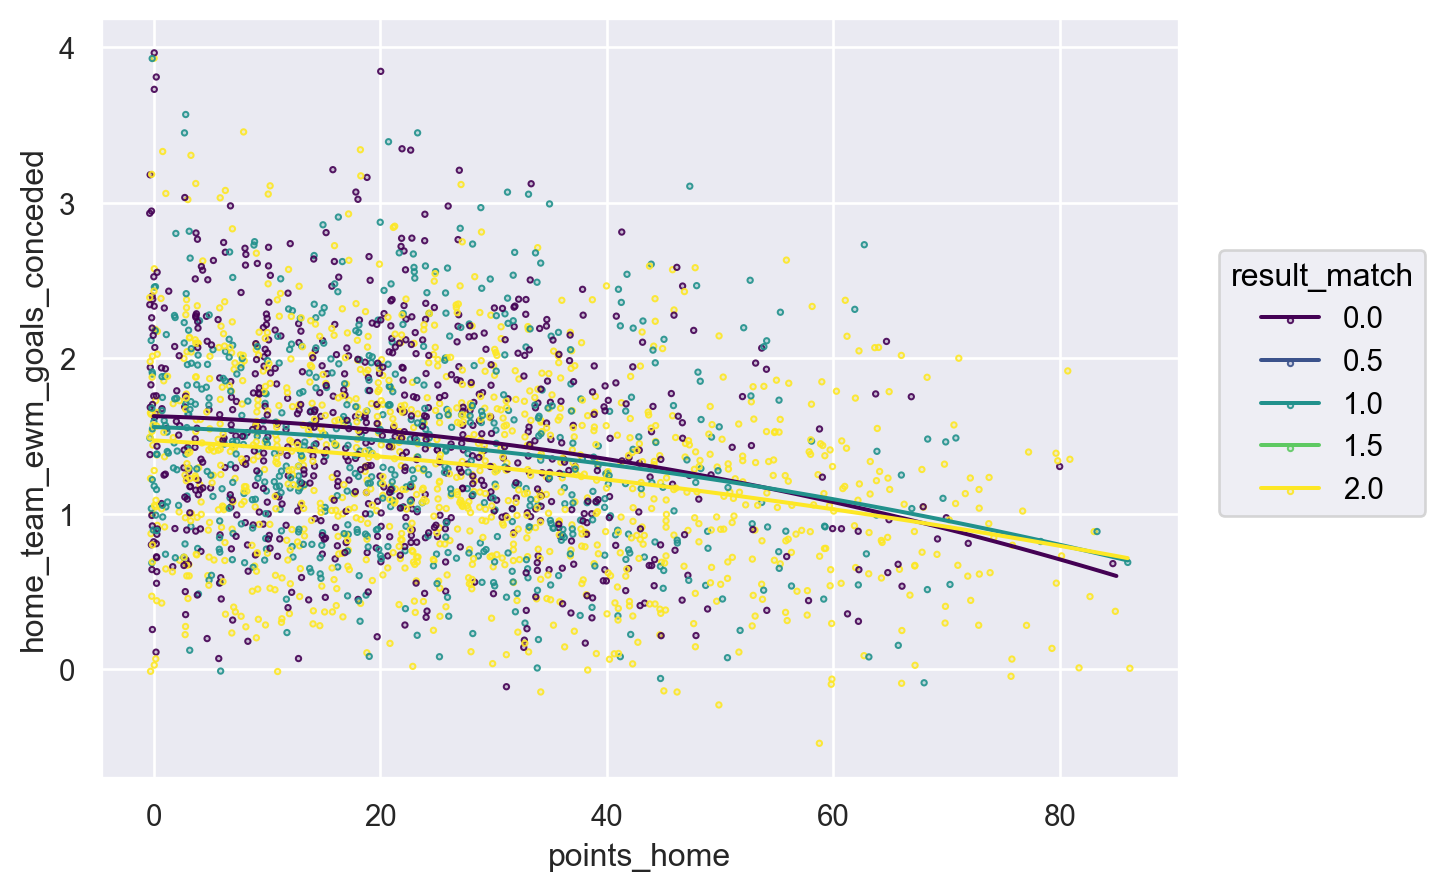

<Figure size 1200x800 with 0 Axes>

In [28]:
import seaborn.objects as so
fig = plt.figure(figsize=(12, 8))
(so.Plot(X_train_full.assign(result_match=y_train), x='points_home', y='home_team_ewm_goals_conceded',color='result_match')
 .add(so.Dots(alpha=.9, pointsize=2), so.Jitter(x=.7, y=1))
 .add(so.Line(), so.PolyFit())
 .scale(color='viridis')
 # .on(fig) # not required unless saving to image
 .plot()) # ditto


In [29]:
constraints = [['away_team_ewm_goals_conceded', 'points_away'], ['away_streak_wins', 'diff_avg_rating_attack'],
               ['away_streak_wins', 'diff_avg_rating_attack'], ['avg_away_team_rating', 'diff_player_1'],
               ['away_streak_wins', 'diff_player_11'], ['home_team_ewm_goals_conceded', 'stage'],
               ['avg_away_team_rating', 'ewma_shoton_home'], ['diff_player_1', 'points_home'],
]

In [30]:
def flatten(seq):
    res = []
    for sub in seq:
        res.extend(sub)
    return res
    
small_cols = sorted(set(flatten(constraints)))
print(small_cols)

['avg_away_team_rating', 'away_streak_wins', 'away_team_ewm_goals_conceded', 'diff_avg_rating_attack', 'diff_player_1', 'diff_player_11', 'ewma_shoton_home', 'home_team_ewm_goals_conceded', 'points_away', 'points_home', 'stage']


In [31]:
def create_interaction_features(data, interactions, depth):
    df_ = data.copy()
    new_features = []
    for interaction in interactions:
        features = interaction.split('|')
        if len(features) == depth:
            # Creating a unique feature name
            new_feature_name = '_'.join(features) + '_interaction'
            new_features.append(new_feature_name)

            data[new_feature_name] = data[features].prod(axis=1)
    return data, new_features

In [32]:
import os

# Extracting all interactions from both 'Interaction Depth 1' and 'Interaction Depth 2'
all_interactions_depth_1 = interaction_depth_1_head['Interaction']
all_interactions_depth_2 = interaction_depth_2_head['Interaction']

output_dir = "../data/cols/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# all_interactions_depth_1.to_csv(output_dir + 'interactions_depth_1.csv', index=False)
# all_interactions_depth_2.to_csv(output_dir + 'interactions_depth_2.csv', index=False)

# Creating new features for all interactions in depth 1 and 2
data, new_features_all_depth_1 = create_interaction_features(df_, all_interactions_depth_1, 2)
data, new_features_all_depth_2 = create_interaction_features(df_, all_interactions_depth_2, 3)

# Displaying the number of new features created for each depth and the updated shape of the dataset
len(new_features_all_depth_1), len(new_features_all_depth_2), data.shape

(20, 20, (3040, 68))

In [36]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel

# Splitting the original dataset
X = df.drop(cols_to_remove, axis=1)
y = df['result_match']
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the XGBClassifier
xgb_full = XGBClassifier(random_state=42)

# Train the model on the full feature set
xgb_full.fit(X_train_full, y_train)

# Predictions and evaluation on the full feature set
y_pred_full = xgb_full.predict(X_test_full)
f1 = f1_score(y_test, y_pred_full, average='weighted')
print(f"F1 with full feature set: {f1}")

# Extracting feature importance
feature_importances = xgb_full.feature_importances_

# Store results
results = []

# Select the most important features
thresholds = sorted(feature_importances, reverse=True)
for thresh in thresholds:
    # Select features using threshold
    selection = SelectFromModel(xgb_full, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_full)

    # Train model
    selection_model = XGBClassifier(random_state=42)
    selection_model.fit(select_X_train, y_train)

    # Evaluate model
    select_X_test = selection.transform(X_test_full)
    y_pred = selection_model.predict(select_X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Storing the results
    results.append({'threshold': thresh, 'n_features': select_X_train.shape[1], 'f1': f1})

# Sorting the results by accuracy
sorted_results = sorted(results, key=lambda x: x['f1'], reverse=True)

# Print the top 5 results
print("Top 5 feature selection results:")
for result in sorted_results[:5]:
    print(f"Threshold: {result['threshold']}, Number of Features: {result['n_features']}, F1: {result['f1']}")

# Sorting the results by F1 score and selecting the best one
best_result = max(results, key=lambda x: x['f1'])

# Extracting the best feature names
selection = SelectFromModel(xgb_full, threshold=best_result['threshold'], prefit=True)
best_features = X_train_full.columns[selection.get_support()]

# best_features now contains the names of the best set of features
# print(f"Best Feature Set: {list(best_features)}")

F1 with full feature set: 0.4654116307795874
Top 5 feature selection results:
Threshold: 0.03209404647350311, Number of Features: 23, F1: 0.4899702794042594
Threshold: 0.030261896550655365, Number of Features: 24, F1: 0.48743221815991444
Threshold: 0.03437366336584091, Number of Features: 13, F1: 0.4818488170819115
Threshold: 0.03282005712389946, Number of Features: 21, F1: 0.4818445913890764
Threshold: 0.03424433246254921, Number of Features: 15, F1: 0.4757757602419596


In [38]:
output_dir = "../data/transform/"
filename= "df_engineered.csv"

full_path = os.path.join(output_dir, filename)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

_ = X[best_features]
_['result_match'] = y
_.to_csv(full_path, index=False)